# SLU06 - Dealing with Data Problems


In this notebook we will be covering the following:

- Tidy Data
- Data Entry Problems
- Missing Values

In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In a real world scenario, data is almost never ready for applying modeling and/or visualisations.   
There are a lot of work to be done before related to data cleaning.   
This learning notebook covers the most common problems, related to  uncleaned data, and how to approach them. 

## 1. Tidy Data


Tidy datasets are easy to manipulate, model and visualize, and have a specific structure:
* each variable is a column
* each observation is a row
* each type of observational unit is a table

It's easier to explain the principle of Tidy Data by running through examples where this principle is violated, and seeing that following the structure described above yields a much cleaner dataset.

The most common problems with messy datasets are the following:

1) Column headers are values, not variable names;   
2) Multiple variables are stored in one column;   
3) Variables are stored in both rows and columns;   
4) Multiple types of observational units are stored in the same table;   
5) A single observational unit is stored in multiple tables;   


In this notebook we will cover the problems number 1) and 4). If you want, you can check the other ones [here](https://vita.had.co.nz/papers/tidy-data.pdf).

#### Problem: Column headers are values, not variable names

In [2]:
df_messy = pd.read_csv(os.path.join('data', 'column_headers_are_values.csv'), sep=' ')
df_messy

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Don’t know/refused,15,14,15,11,10,35
5,Evangelical Prot,575,869,1064,982,881,1486
6,Hindu,1,9,7,9,11,34
7,Historically Black Prot,228,244,236,238,197,223
8,Jehovah’s Witness,20,27,24,24,21,30
9,Jewish,19,19,25,25,30,95


In the above dataset, we have two variables: `religion` and `income`.
The Tidy Data principle is not being followed because the `income` variable is represented as multiple columns, instead of just one column.

Using this data representation, it becomes kind of complicated to answer questions like "How many people with the Buddhist religion earn between \\$10k and \\$40k?".

In [3]:
# How many people with the Buddhist religion earn between $10k and $40k? - with messy data
df_messy[df_messy.religion == 'Buddhist'][['$10-20k', '$20-30k', '$30-40k']].sum(axis=1).values[0]

85

The above query is a very unnatural one: first we're subsetting rows to get the right religion, then we subset columns to get the right income values, finally we do a messy sum to get the counts.

We can tidy up this data using method [`melt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html), as shown here.

In [4]:
# Getting the income values from the column names, except 'religion'
income_values = list(filter(lambda x: x != 'religion', df_messy.columns.tolist()))
print(f"Income values stored in the columns:\n{income_values}")

# Using the melt function to 'melt' the income_values into a column
df_tidy = pd.melt(df_messy, id_vars=['religion'], value_vars=income_values, var_name='income', value_name='freq')
df_tidy.head()

Income values stored in the columns:
['<$10k', '$10-20k', '$20-30k', '$30-40k', '$40-50k', '$50-75k']


,religion,income,freq
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15


As you can see, the column names, with exception of religion, are now the unique values of column `income`. We also have a new column named `freq`. On column `freq` it is represented the value that is on the same row and column of the correspondent `religion` and `income`, respectively, on DataFrame `df_messy`.

In [5]:
# How many people with the Buddhist religion earn between $10k and $40k? - with tidy data
df_tidy[(df_tidy.religion == 'Buddhist') & (df_tidy.income.isin(['$10-20k', '$20-30k', '$30-40k']))].freq.sum()

85

Now the query becomes easier to understand: first we subset the rows with the desired value for religion **AND** income, then we just sum the frequencies to get the final value.

#### Problem: Multiple types of observational units are stored in the same table

In [6]:
df_messy = pd.read_csv(os.path.join('data', 'multiple_types.csv'))
df_messy

,year,artist,track,time,date.entered,wk1,wk2,wk3
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,87,82,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,91,87,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,81,70,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,97,97,96
4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29,84,62,51
5,2000,Aaliyah,Try Again,4:03,2000-03-18,59,53,38
6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26,76,76,74
7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15,50,39,30


In this dataset, we have data from a music billboard: each observation is a song in the billboard, and the columns have information about the following variables:
* `year` the billboard reports to
* `artist`
* `track` name
* `time`, which is the track duration 
* `date.entered`, which is the date when the song entered the billboard
* `wk1`, `wk2` and `wk3`: position of the song in the billboard per week of the year

Now, the first problem that we can see is that the `wk1`, `wk2` and `wk3` all refer to the same variable, which is the position of the song in the billboard per week of the year. So we can take care of these like we did in the previous example.

In [7]:
id_vars = ['year', 'artist', 'track', 'time', 'date.entered']
value_vars = ['wk1', 'wk2', 'wk3']
df_melted = pd.melt(df_messy, id_vars=id_vars, value_vars=value_vars, var_name='week', value_name='position')
df_melted.sort_values(['artist', 'week']).head(10)

,year,artist,track,time,date.entered,week,position
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk1,87
8,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk2,82
16,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk3,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk1,91
9,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk2,87
17,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk3,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk1,81
10,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk2,70
18,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk3,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,wk1,97


Now, the problem that we can see here is that we're trying to represent two observational units in the same table: one is the song itself, the other is its billboard position in a certain point in time.

It is better to split these two types of observational units into two tables. However, we should have a way to relate both. We need to mantain a correspondence, a mapping id, for these two tables. If in future, we need to put the pieces together, with a mapping id we are able to join again the DataFrames. 

As the main table doesn't have any unique id, we need to create one. 

In [8]:
# In one table we store the songs, and give it an id
df_messy['song_id'] = range(len(df_messy))
df_songs = df_messy[['song_id'] + id_vars]
df_songs

,song_id,year,artist,track,time,date.entered
0,0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26
1,1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02
2,2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08
3,3,2000,A*Teens,Dancing Queen,3:44,2000-07-08
4,4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29
5,5,2000,Aaliyah,Try Again,4:03,2000-03-18
6,6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26
7,7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15


In [9]:
# In the other table, we keep the positions per week and the song_id
df_positions = pd.melt(df_messy, id_vars=['song_id'], value_vars=value_vars, var_name='week', value_name='position')
df_positions = df_positions.sort_values(['song_id', 'week']).reset_index(drop=True)
df_positions.head()

,song_id,week,position
0,0,wk1,87
1,0,wk2,82
2,0,wk3,72
3,1,wk1,91
4,1,wk2,87


---

## 2. Data Entry Problems

To ilustrate what those problems look like, let's upload the following DataFrame.

In [10]:
data = pd.read_csv(os.path.join('data', 'data_with_problems.csv'), index_col=0)
print(f"This dataset has {len(data)} observations.")
data.head(10)

This dataset has 200 observations.


,age,height,gender
CFLOXRHMDR,88.0,163.0,female
FXLJSNLSOG,29.0,158.0,female
FWDIVJKGOI,42.0,159.0,female
YWEBKQWHRE,25.0,179.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
SSZQEGTLNK,NaN,162.0,male
PRFEFXNGWN,36.0,166.0,female


In this DataFrame, we have:
* 3 variables: `age`, `height` and `gender`. The first two are `numerical` variables while the last one is `categorical`.
* 200 observations

As the Tidy Data guidelines suggest, we have each of these variables in a column of our DataFrame, so we're good.

Based on the names of our variables, we can conclude that each row (observation) represents a person.

**Data entry problems** usually occur when an agent (usually a dumb human!) is transcribing information into an electronic medium.

Typical data entry problems are:
- Case mismatches in text fields
- Grammar errors (_typos_) in text fields
- Wrong data types
- Non-sense values (or “I really don’t know what to write here but this form forces me to write something...”)
- Missing values
- Duplicated observations
- and a lot more!

![image.png](media/cat_typing.gif)

These problems need to be resolved before jumping in a more analytical process, if not, it can lead to not accurate results.

### 2.1 Data entry problems in categorical variables

Let's take a look at our categorical feature `gender`, using two functions: [value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) and [nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html).

With `nunique` method we can get the number of unique values found in this `pd.Series`.

In [11]:
data.gender.nunique()

7

It seems that there are 7 unique values for gender, which is unexpected...

Using `value_counts` method, we can get counts per unique value.

In [12]:
data.gender.value_counts()

female       109
male          66
MALE           9
m              3
F              2
f              1
   female      1
Name: gender, dtype: int64

Ok, it seems that for most of the observations we have `gender` with values female or male, but there are some cases where we have different values: MALE, m, F, f,    female (with leading blank spaces).

To clean this data, we can do **string manipulation** directly on the DataFrame!
We can apply a python string method to all the elements in a pandas Series by calling `.str` on the Series, followed by the string method.

For instance, let's convert all the strings in the `gender` column to lower case, using [`str.lower`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.lower.html).

In [13]:
data.gender = data.gender.str.lower()
data.gender.value_counts()

female       109
male          75
f              3
m              3
   female      1
Name: gender, dtype: int64

As we can see, this converted all the cases of `MALE` (which were 9) to `male` (before: 66 observations, after: 75 observations).

Also, all the cases of `F` (which were 2), were converted to `f` (before: 1 observation, after: 3 observations).

Not super useful in this context, but still worth mentioning that [`str.lower`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.lower.html) has a sister, called [`str.upper`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html), that does exactly the opposite: converts the strings to uppercase.

In [14]:
data.gender.str.upper().value_counts()

FEMALE       109
MALE          75
F              3
M              3
   FEMALE      1
Name: gender, dtype: int64

Let's clean this data a bit more: using [`str.strip`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.strip.html), we'll remove leading and trailing whitespaces from the strings in the `gender` column.

In [15]:
data.gender = data.gender.str.strip()
data.gender.value_counts()

female    110
male       75
f           3
m           3
Name: gender, dtype: int64

The string `female` with leading whitespaces was converted to `female`, without the whitespaces!

Next we need to replace `m` with `male` and `f` with `female`.
We can do that using the [`str.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html) method, that receives as arguments a pattern and a replacement.

In [16]:
# Note that here we're not changing the values in data.gender, we're just outputting them!
data.gender.str.replace('m', 'male').value_counts()

femaleale    110
maleale       75
f              3
male           3
Name: gender, dtype: int64

Wait... something is weird!

What happens is that str.replace replaces **any** occurrences of the pattern in the Series values, even if they appear in the middle of something!
We can fix this in two ways.

**First option**: the pattern received by str.replace can be a **regex**. Using a regex, we can specify that we want to replace the string `m` with `male`, but only when it appears alone.

In [17]:
data.gender.str.replace('^m$', 'male').value_counts()

female    110
male       78
f           3
Name: gender, dtype: int64

And we can chain two of these operations together in order to handle the two replacements at the same time.
Notice that we need to call `.str` again.

In [18]:
data.gender.str.replace('^m$', 'male').str.replace('^f$', 'female').value_counts()

female    113
male       78
Name: gender, dtype: int64

**Second option**: instead of using the [`str.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html) method, we can use the [`replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) method, that receives as argument a dictionary with the full-word replacements we want to do.

In [19]:
data.gender = data.gender.replace({'m': 'male', 'f': 'female'})
data.gender.value_counts()

female    113
male       78
Name: gender, dtype: int64

The `gender` variable is looking better!

Now, if you noticed at the beginning of the notebook, we counted 200 observations in our dataset. However `113 + 78 = 191`...

The problem we have here is that the [`value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) method doesn't count null values by default. If we want to count those, we need to set the argument `dropna=False`.

Let's see how to do that and also how to visualise the value counts using a barplot.

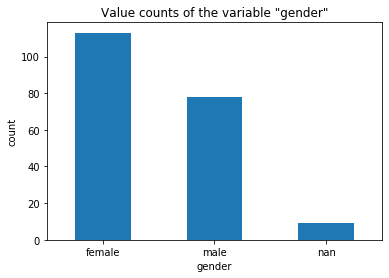

In [20]:
data.gender.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.ylabel('count')
plt.xlabel('gender')
plt.title('Value counts of the variable "gender"')
plt.show()

We've seen how to use some string methods directly on Series. There are many more string methods available, but we'll just see two more useful methods, which are [`str.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html) and [`str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html).

Say we had a birthdate column in our dataset.

In [21]:
data_with_bd = pd.read_csv(os.path.join('data', 'data_with_problems_and_birthdays.csv'))
data_with_bd.head()

,age,height,gender,birthdate
0,88.0,163.0,female,1942-02-27
1,29.0,158.0,female,1946-03-31
2,42.0,159.0,female,1946-09-13
3,25.0,179.0,male,1947-08-25
4,32.0,169.0,male,1954-01-24


We could use the [`str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) method to split the date into year, month and day.

In [22]:
dates = data_with_bd.birthdate.str.split(pat='-', expand=True)
dates.columns = ['year', 'month', 'day']
dates.head()

,year,month,day
0,1942,02,27
1,1946,03,31
2,1946,09,13
3,1947,08,25
4,1954,01,24


And, we could merge it back together with [`str.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html).

In [23]:
dates['moth_year'] = dates.month.str.cat(dates.year, sep='/')
dates.head()

,year,month,day,moth_year
0,1942,02,27,02/1942
1,1946,03,31,03/1946
2,1946,09,13,09/1946
3,1947,08,25,08/1947
4,1954,01,24,01/1954


### 2.2 Data entry problems in numerical variables

These data entry problems can also happen in numerical variables.   

Let's go back to `data` DataFrame and look closely to feature `age`.

Having this page as a baseline [oldest person ever](https://www.guinnessworldrecords.com/world-records/oldest-person), let's set the maximum possible age at 123, and the lowest at 0.   
Let's see if there are any values out of this range.

In [24]:
data.age[(data.age<0) | (data.age>123)]

TSHRBGFOJU    300000000.0
SQYVEHAWSW          224.0
Name: age, dtype: float64

We can handle these values as if they were missing values. For that purpose, let's replace these values with `np.nan`. 

In [25]:
data.loc[(data.age<0) | (data.age>123), "age"] = np.nan
data.loc[["TSHRBGFOJU", "SQYVEHAWSW"]]

,age,height,gender
TSHRBGFOJU,NaN,184.0,female
SQYVEHAWSW,NaN,166.0,male


Note: On section 3 we will explain how to deal with missing values.

With these sections, 2.1 and 2.2, we conclude how important it is to always look carefully and with a critical view to the unique values of each feature, categorical or numerical.

### 2.3 Duplicated entries

First we need to define what a duplicate is in the context of our problem. Then we can search for duplicated entries and drop them from the dataset.

In our case, each row (observation) corresponds to a person, for which we know an ID (in the index), age, height and gender. Let's define as duplicate the case where two rows or more are exact matches, i.e, the index and the values in all the columns are the same.

We can find duplicates using method [`duplicated()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html) and drop duplicated data with [`drop_duplicates()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html).

In [26]:
# Can you find some duplicates in the 10 first observations?
data.head(10)

,age,height,gender
CFLOXRHMDR,88.0,163.0,female
FXLJSNLSOG,29.0,158.0,female
FWDIVJKGOI,42.0,159.0,female
YWEBKQWHRE,25.0,179.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
SSZQEGTLNK,NaN,162.0,male
PRFEFXNGWN,36.0,166.0,female


In [27]:
duplicated_mask = data.duplicated(keep='first')

print('Number of duplicates:', duplicated_mask.sum())

Number of duplicates: 6


So we have 6 entries which are duplicated! How do they look like?

In [28]:
data[duplicated_mask]

,age,height,gender
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
YPUQAPSOYJ,32.0,169.0,male
XUAJJPLVOI,18.0,168.0,female
TRMMGYEEPC,21.0,156.0,female
ZNLRYQHPXJ,25.0,155.0,male


So, these are the duplicated observations. This means that for each unique observation above we have at least another one in our dataset.

Notice the `keep='first'` in `data.duplicated(...)` means that all the duplicates are flagged as True, except for the first. For example, there are a total of 4 rows with index `YPUQAPSOYJ`, but only 3 in the duplicated_mask.

How can we drop all duplicates except for the first occurrence?

In [29]:
print(f"Shape before dropping duplicates: {data.shape}")
data = data.drop_duplicates()
print(f"Shape after dropping duplicates: {data.shape}")

Shape before dropping duplicates: (200, 3)
Shape after dropping duplicates: (194, 3)


Makes sense, since we deleted 6 duplicates.

---

## 3. Missing Values 

Missing values on a dataset is also a very common problem. And as further steps on the data science pipeline can not be compatible with missing values. Because of that, depending on the task you may need to deal with these values before.

### 3.1 How to detect missing values

In order to find out what are the missing values, we can use method [`isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html), followed by [`sum`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html) to count how many missing values do we have per column.

In [30]:
data.isnull().tail()

,age,height,gender
AGFHBQDTEG,False,False,False
HYTVHSPPVG,False,False,False
DSBFYTZEQN,False,False,False
VYAQBLJKXJ,True,False,False
BLAKTCGBMO,False,False,False


In [31]:
data.isnull().sum()

age       11
height     4
gender     9
dtype: int64

We have missing values in all columns. What are the rows with at least one missing value?   
To answer this question, we will use the method [any](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.any.html).

In [32]:
# For each row, we get True if any of the columns is null and False otherwise
mask = data.isnull().any(axis=1)

# We select the rows for which the mask is True
data[mask]

,age,height,gender
SSZQEGTLNK,NaN,162.0,male
CWCFROPRFE,22.0,NaN,male
TJQPFEFVVH,NaN,182.0,NaN
PYHWLDVICX,NaN,181.0,female
MLRPKGKACD,NaN,185.0,male
TSHRBGFOJU,NaN,184.0,female
SGMGUJEBNC,NaN,173.0,male
EORSIPDIHA,21.0,NaN,male
YZDOYNOXAF,NaN,144.0,female
QXUGUHCOPT,101.0,196.0,NaN


### 3.2 Handling missing values

This is probably the biggest data problem we generally face. There are several ways to deal with missing values, let's see some of them.

**Dropping missing values**

The simplest way to handle missing values is to simply discard the rows with missing values.

We can do this using method [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html). This method drops all the rows with any missing values from a DataFrame.

In [33]:
print(f"Shape before dropping missing values: {data.shape}")
data_no_missing_values = data.dropna()
print(f"Shape after dropping missing values: {data_no_missing_values.shape}")

Shape before dropping missing values: (194, 3)
Shape after dropping missing values: (171, 3)


**Replacing with the mean or median**

For numerical variables with missing values, we can replace the missing values with the mean or median of that variable.

It's practically the same to chose the mean or the median, but the median is less sensible to outliers in your variable.

For this, we can use method [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html), together with value that we think is the best to replace it. The most used are [`mean`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) or [`median`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.median.html).

In our case, let's see how to replace missing values in the `age` column, with the median.

In [34]:
print(f"Missing values in the age column before: {data.age.isnull().sum()}")
age_without_missing_values = data.age.fillna(data.age.median())
print(f"Missing values in the age column after: {age_without_missing_values.isnull().sum()}")

Missing values in the age column before: 11
Missing values in the age column after: 0


**Replacing with a new category**

For categorical variables, we can replace missing values with a new category, called `unknown`, for instance.

This makes it clearer that there is missing information and we don't allow Pandas to trick us with its default of ignoring missing values :)

Let's see how we can replace missing values in the `gender` column. We can use method [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) again.

In [35]:
print(f"Missing values in the gender column before: {data.gender.isnull().sum()}")
gender_without_missing_values = data.gender.fillna('unknown')
print(f"Missing values in the age column after: {gender_without_missing_values.isnull().sum()}")

Missing values in the gender column before: 9
Missing values in the age column after: 0


In [36]:
gender_without_missing_values.value_counts()

female     111
male        74
unknown      9
Name: gender, dtype: int64

**Pro tip**

We can call [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) with a dictionary and handle all these replacements at the same time!

In [37]:
data = data.fillna({
    'age': data.age.median(),
    'height': data.height.median(),
    'gender': 'unknown'
})

print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


And we're good to go!

**Important Note**

The ways we saw on how to impute missing data are the mechanical ways to handle missing data (_Kaggle style_).
However, you can act in a smarter way: understand the real nature of the missing value and act individually; understand why it is missing, and whether it should be missing, or not.

For example, if you have missing values in a `height` feature, it might make more sense to replace the missing values according to the `gender` of each observation instead of replacing all missing values by the median of the entire population.

You can give it a try and see if the results make more sense!

---

Now that we are masters at cleaning, we can jump into the exercises!

![](media/giphy.gif)